In [11]:
import pandas as pd
# Importar utilidades para gestión de rutas
from cedenar_anomalies.utils.paths import (
    data_processed_dir,
    data_raw_dir,
    data_interim_dir,
    models_dir
)

In [12]:
models_dir()

PosixPath('/Users/frandak2/Documents/repos/cedenar_anomalies/models')

In [13]:
# from fcmeans import FCM

In [14]:
pd.set_option("display.max_rows", None)  # Mostrar todas las filas
pd.set_option("display.max_columns", None)  # Mostrar todas las columnas

### Se ingresa la  sabana de datos limpia

## Unir a previo a encode

In [15]:
import pandas as pd

In [16]:
df_anomaly_encoded = pd.read_csv(data_processed_dir("dataset_train_clean.csv"))

In [17]:
df_anomaly_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260800 entries, 0 to 260799
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Orden           260800 non-null  int64  
 1   Usuario         260800 non-null  int64  
 2   Ejecucion       260800 non-null  object 
 3   Codigo          256136 non-null  object 
 4   Descripcion     260800 non-null  object 
 5   Motivo          255439 non-null  object 
 6   kWh Rec         209785 non-null  float64
 7   Factor          3112 non-null    float64
 8   id              250692 non-null  float64
 9   Nombre          250692 non-null  object 
 10  Factor.1        3112 non-null    float64
 11  AREA            260789 non-null  object 
 12  PLAN_COMERCIAL  260789 non-null  object 
 13  TRAFO_OPEN      260658 non-null  object 
 14  FASES           258909 non-null  float64
 15  KVA             260557 non-null  float64
 16  LATI_USU        260557 non-null  float64
 17  LONG_USU  

In [18]:
df_anomaly_encoded.columns

Index(['Orden', 'Usuario', 'Ejecucion', 'Codigo', 'Descripcion', 'Motivo',
       'kWh Rec', 'Factor', 'id', 'Nombre', 'Factor.1', 'AREA',
       'PLAN_COMERCIAL', 'TRAFO_OPEN', 'FASES', 'KVA', 'LATI_USU', 'LONG_USU',
       'puntaje', 'evaluacion', 'Zona'],
      dtype='object')

In [19]:
columnas_deseadas = [
    "Usuario", "AREA", "PLAN_COMERCIAL", "LATI_USU", "LONG_USU",'puntaje', 'evaluacion'
]

In [10]:
df_anomaly_encoded[columnas_deseadas].sample(5)

,Usuario,AREA,PLAN_COMERCIAL,LATI_USU,LONG_USU,puntaje,evaluacion
123580,358682,Rural,2-PLAN RESIDENCIAL,1.609366,-77.111654,5.0,3.0
172591,8534945,Rural,2-PLAN RESIDENCIAL,1.516919,-77.563305,1.0,1.0
7002,1089585,Urbano,2-PLAN RESIDENCIAL,1.197263,-77.284553,5.0,3.0
236669,535895,Urbano,2-PLAN RESIDENCIAL,1.200263,-77.280304,4.0,3.0
164427,156962,Rural,2-PLAN RESIDENCIAL,1.312208,-77.381803,5.0,3.0


In [20]:
import logging
from typing import Dict, Optional
import pandas as pd
import joblib
from pathlib import Path
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from fcmeans import FCM
from skfda.ml.clustering import FuzzyCMeans

# Importar utilidades para gestión de rutas
from cedenar_anomalies.utils.paths import models_dir

class SklearnFCMWrapper(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3, m=2.0, random_state=42, distance = 'euclidean', logger: Optional[logging.Logger] = None):
        self.n_clusters = n_clusters
        self.m = m
        self.random_state = random_state
        self.distance = distance
        self.logger = logger or logging.getLogger(self.__class__.__name__)

    def fit(self, X, y=None):
        self.logger.info(f"Entrenando FCM con {self.n_clusters} clusters y m={self.m}")
        self.model_ = FCM(n_clusters=self.n_clusters,
                          m=self.m,
                          random_state = self.random_state,
                          distance = self.distance)
        self.model_.fit(X)
        self.labels_ = self.model_.predict(X)
        self.centers_ = self.model_.centers
        self.u_ = self.model_.u
        self.pc_ = self.model_.partition_coefficient
        self.pec_ = self.model_.partition_entropy_coefficient
        self.logger.info("Entrenamiento FCM completo.")
        return self

    def predict(self, X):
        self.logger.info("Realizando predicción con FCM.")
        return self.model_.predict(X)

    def soft_predict(self, X):
        self.logger.info("Realizando soft predicción con FCM.")
        return self.model_.soft_predict(X)


class PipelineClusterFzz:
    def __init__(self, n_clusters=3, m=2, distance= 'euclidean', model_dir=models_dir(), scores_path="silhouette_scores.csv",  logger: Optional[logging.Logger] = None):
        self.n_clusters = n_clusters
        self.model_dir = model_dir
        self.distance = distance
        self.m = m
        self.scores_path = models_dir(f'{distance}_{scores_path}')
        self.model_dir.mkdir(parents=True, exist_ok=True)
        self.scores = []
        self.numerical_cols = ["Usuario", "LATI_USU", "LONG_USU"]
        self.categorical_cols = ["AREA", "PLAN_COMERCIAL"]
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.info("Inicializando PipelineClusterFzz")

    def build_pipeline(self):
        self.logger.info("Construyendo pipeline de preprocesamiento y clustering.")

        # self.numerical_cols = ["kWh Rec", "FASES", "KVA", "LATI_USU", "LONG_USU", "puntaje", "evaluacion"]
        # self.categorical_cols = ["AREA", "PLAN_COMERCIAL"]


        numeric_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ])

        categorical_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("labelenc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ])

        preprocessor = ColumnTransformer([
            ("num", numeric_pipeline, self.numerical_cols),
            ("cat", categorical_pipeline, self.categorical_cols)
        ])

        pipeline = Pipeline([
            ("preprocess", preprocessor),
            ("cluster", SklearnFCMWrapper(n_clusters=self.n_clusters,
                                          m=self.m,
                                          random_state=42,
                                          distance= self.distance,
                                          logger=self.logger))
            # ("cluster", FuzzyCMeans(n_clusters=self.n_clusters, random_state=42))  #m=2.0
        ])

        return pipeline

    def fit(self, df: pd.DataFrame, zona: str) -> Pipeline:
        self.logger.info(f"Iniciando entrenamiento para zona: {zona}")
        df_zone = df[df["Zona"] == zona].copy()
        pipeline = self.build_pipeline()
        pipeline.fit(df_zone)
        self.logger.info(f"Entrenamiento completado para zona: {zona}")
        return pipeline

    def predict(self, pipeline: Pipeline, df: pd.DataFrame) -> pd.DataFrame:
        self.logger.info("Iniciando predicción con pipeline entrenado.")
        df = df.copy()

        # Transformar los datos con el preprocesador
        X_transformed = pipeline.named_steps["preprocess"].transform(
            df[self.categorical_cols + self.numerical_cols]
        )

        # Obtener cluster duro
        labels = pipeline.named_steps["cluster"].predict(X_transformed)
        df["cluster_id"] = labels

        # Obtener cluster suave
        matrix_pertenencia = pipeline.named_steps["cluster"].soft_predict(X_transformed)
        cluster_columns = [f"cluster_{i}" for i in range(matrix_pertenencia.shape[1])]
        matrix_pertenencia_df = pd.DataFrame(matrix_pertenencia, columns=cluster_columns)

        # Unir con el dataframe original
        df = pd.concat([df.reset_index(drop=True), matrix_pertenencia_df.reset_index(drop=True)], axis=1)
        return df


    def train_by_zone(self, df: pd.DataFrame) -> dict:
        pipelines = {}
        silhouette_scores = []

        self.logger.info("Entrenando pipelines por zona.")
        for zona in df["Zona"].unique():
            self.logger.info(f"Procesando zona: {zona}")
            df_zone = df[df["Zona"] == zona].copy()
            pipeline = self.fit(df, zona)
            df_with_clusters = self.predict(pipeline, df_zone)

            X_transformed = pipeline.named_steps["preprocess"].transform(
                df_zone[self.categorical_cols + self.numerical_cols]
            )
            score = silhouette_score(X_transformed, df_with_clusters["cluster_id"])
            self.logger.info(f"Índice de silueta para zona {zona}: {score:.4f}")

            pc = pipeline.named_steps["cluster"].pc_
            pec = pipeline.named_steps["cluster"].pec_

            joblib.dump(pipeline, self.model_dir / f"pipeline_{zona}.pkl")
            self.logger.info(f"Pipeline guardado para zona {zona}")

            silhouette_scores.append({"zona": zona, "silhouette_score": score, "PC":pc , "PEC": pec})
            pipelines[zona] = pipeline

        pd.DataFrame(silhouette_scores).to_csv(self.scores_path, index=False)
        self.logger.info(f"Scores de silueta guardados en: {self.scores_path}")
        return pipelines

    def predict_all_zones(self, df: pd.DataFrame, pipelines: dict) -> pd.DataFrame:
        self.logger.info("Iniciando predicción en todas las zonas.")
        df_all = []
        for zona, pipeline in pipelines.items():
            self.logger.info(f"Prediciendo zona: {zona}")
            df_zone = df[df["Zona"] == zona].copy()
            df_clustered = self.predict(pipeline, df_zone)
            df_all.append(df_clustered)
        return pd.concat(df_all, ignore_index=True)

    def load_pipelines(self) -> dict:
        self.logger.info("Cargando pipelines guardados desde disco.")
        pipelines = {}
        for model_file in self.model_dir.glob("pipeline_*.pkl"):
            zona = model_file.stem.replace("pipeline_", "")
            pipelines[zona] = joblib.load(model_file)
            self.logger.info(f"Pipeline cargado para zona: {zona}")
        return pipelines


In [21]:
# Configurar logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [22]:
pipe = PipelineClusterFzz(m = 1.5, logger=logger)
list_pipe = pipe.train_by_zone(df=df_anomaly_encoded)

2025-05-29 11:43:30,443 - INFO - Inicializando PipelineClusterFzz
2025-05-29 11:43:30,443 - INFO - Entrenando pipelines por zona.
2025-05-29 11:43:30,448 - INFO - Procesando zona: CE
2025-05-29 11:43:30,459 - INFO - Iniciando entrenamiento para zona: CE
2025-05-29 11:43:30,469 - INFO - Construyendo pipeline de preprocesamiento y clustering.
2025-05-29 11:43:30,481 - INFO - Entrenando FCM con 3 clusters y m=1.5
2025-05-29 11:43:30,757 - INFO - Entrenamiento FCM completo.
2025-05-29 11:43:30,759 - INFO - Entrenamiento completado para zona: CE
2025-05-29 11:43:30,765 - INFO - Iniciando predicción con pipeline entrenado.
2025-05-29 11:43:30,777 - INFO - Realizando predicción con FCM.
2025-05-29 11:43:30,781 - INFO - Realizando soft predicción con FCM.
2025-05-29 11:43:36,791 - INFO - Índice de silueta para zona CE: 0.7566
2025-05-29 11:43:36,794 - INFO - Pipeline guardado para zona CE
2025-05-29 11:43:36,794 - INFO - Procesando zona: OC
2025-05-29 11:43:36,804 - INFO - Iniciando entrenamie

In [25]:
pipeline_pa = list_pipe["PA"]
pipeline_pa

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Usuario', 'LATI_USU',
                                                   'LONG_USU']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('labelenc',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['AREA',
                                                   'PLAN_COMERCIAL'])])),
                ('cluster',
                 SklearnFCMWrapper(logger=<Logger PipelineClusterFzz (INFO)>,
                                   m=1.5))])

In [26]:
fcm_centers_pipe = pipeline_pa.named_steps["cluster"].centers_
fcm_labels_pipe = pipeline_pa.named_steps["cluster"].labels_
fcm_u_pipe = pipeline_pa.named_steps["cluster"].u_

In [27]:
data_pa = df_anomaly_encoded[df_anomaly_encoded.Zona=='PA']
df_selected = pipeline_pa.named_steps["preprocess"].transform(data_pa)

In [28]:
pipeline_pa.predict(data_pa)

2025-05-29 11:45:42,966 - INFO - Realizando predicción con FCM.


array([0, 1, 1, ..., 0, 0, 0])

In [29]:
pipeline_pa.named_steps["cluster"].soft_predict(df_selected)

2025-05-29 11:45:43,024 - INFO - Realizando soft predicción con FCM.


array([[9.98192333e-01, 1.19003898e-03, 6.17627745e-04],
       [3.69242285e-02, 9.55824154e-01, 7.25161736e-03],
       [3.05184913e-02, 9.63543635e-01, 5.93787373e-03],
       ...,
       [9.56826840e-01, 3.78365994e-02, 5.33656040e-03],
       [9.56826840e-01, 3.78365994e-02, 5.33656040e-03],
       [9.56826840e-01, 3.78365994e-02, 5.33656040e-03]])

In [30]:
data_pa = pipe.predict(df=data_pa.copy(), pipeline=pipeline_pa)
data_pa.head(2)

2025-05-29 11:45:43,095 - INFO - Iniciando predicción con pipeline entrenado.
2025-05-29 11:45:43,124 - INFO - Realizando predicción con FCM.
2025-05-29 11:45:43,136 - INFO - Realizando soft predicción con FCM.


,Orden,Usuario,Ejecucion,Codigo,Descripcion,Motivo,kWh Rec,Factor,id,Nombre,Factor.1,AREA,PLAN_COMERCIAL,TRAFO_OPEN,FASES,KVA,LATI_USU,LONG_USU,puntaje,evaluacion,Zona,cluster_id,cluster_0,cluster_1,cluster_2
0,10699622,1149695,2022-01-04 10:22:40-05,EEM,Posible anomalia,NaN,0.0,NaN,27.0,ELEMENTO EXTRANO DENTRO,NaN,Urbano,2-PLAN RESIDENCIAL,60TA011002,1.0,75.0,1.805776,-78.776637,5.0,3.0,PA,0,0.998192,0.001190,0.000618
1,11168065,544326,2021-03-27 08:04:44-05,30004,Anomalia verificada y aprobada,Otras Anomalias,NaN,NaN,40.0,OTRAS ANOMALÍAS REINCIDENTE PARE,NaN,Urbano,2-PLAN RESIDENCIAL,05TN000137,2.0,45.0,1.672157,-78.142107,1.0,1.0,PA,1,0.036924,0.955824,0.007252


In [31]:
data_pa["cluster_id"].value_counts()

cluster_id
0    44684
2    39399
1    29936
Name: count, dtype: int64

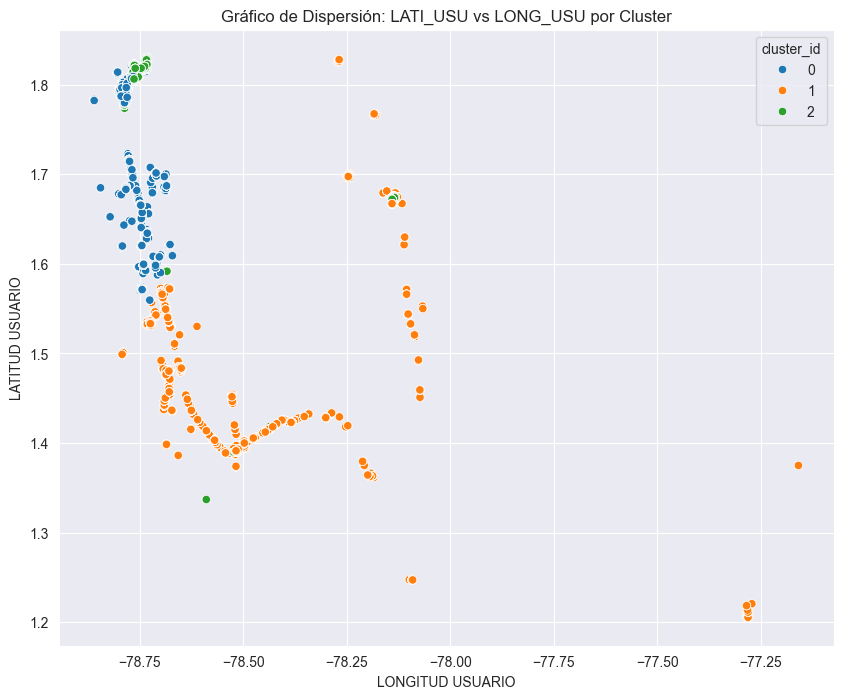

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
# Asegúrate de que 'Cluster' sea numérico o categórico
data_pa["cluster_id"] = data_pa[
    "cluster_id"
].astype(str)  # O numérico si es apropiado

# Crea el gráfico de dispersión con colores basados en 'Cluster'
plt.figure(figsize=(10, 8))  # Ajusta el tamaño de la figura si es necesario
sns.scatterplot(
    x="LONG_USU", y="LATI_USU", hue="cluster_id", data=data_pa
)

# Añade etiquetas y título
plt.title("Gráfico de Dispersión: LATI_USU vs LONG_USU por Cluster")
plt.xlabel("LONGITUD USUARIO")
plt.ylabel("LATITUD USUARIO")

# Muestra la leyenda (automática con 'hue')
plt.legend(title="cluster_id")

# Muestra el gráfico
plt.show()

In [33]:
df = df_anomaly_encoded.copy()
output_path = "dataset_con_clusters.csv"

In [34]:
try:
    pipe = PipelineClusterFzz(logger=logger)
    pipelines = pipe.load_pipelines()

    if not pipelines:
        logger.error("No se encontraron modelos entrenados para predecir.")

    df_predicted = pipe.predict_all_zones(df, pipelines)

    if df_predicted.empty:
        logger.error("La predicción no generó resultados.")

    df_predicted.to_csv(output_path, index=False)
    logger.info(f"Predicción completada y guardada en: {output_path}")

except Exception as e:
    logger.exception(f"Error durante el proceso de predicción: {e}")

2025-05-29 11:45:44,502 - INFO - Inicializando PipelineClusterFzz
2025-05-29 11:45:44,502 - INFO - Cargando pipelines guardados desde disco.
2025-05-29 11:45:44,504 - INFO - Pipeline cargado para zona: PA
2025-05-29 11:45:44,505 - INFO - Pipeline cargado para zona: OC
2025-05-29 11:45:44,507 - INFO - Pipeline cargado para zona: CE
2025-05-29 11:45:44,508 - INFO - Pipeline cargado para zona: NO
2025-05-29 11:45:44,509 - INFO - Pipeline cargado para zona: SU
2025-05-29 11:45:44,509 - INFO - Iniciando predicción en todas las zonas.
2025-05-29 11:45:44,510 - INFO - Prediciendo zona: PA
2025-05-29 11:45:44,528 - INFO - Iniciando predicción con pipeline entrenado.
2025-05-29 11:45:44,553 - INFO - Realizando predicción con FCM.
2025-05-29 11:45:44,567 - INFO - Realizando soft predicción con FCM.
2025-05-29 11:45:44,589 - INFO - Prediciendo zona: OC
2025-05-29 11:45:44,600 - INFO - Iniciando predicción con pipeline entrenado.
2025-05-29 11:45:44,606 - INFO - Realizando predicción con FCM.
2025

In [35]:
df_predicted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260800 entries, 0 to 260799
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Orden           260800 non-null  int64  
 1   Usuario         260800 non-null  int64  
 2   Ejecucion       260800 non-null  object 
 3   Codigo          256136 non-null  object 
 4   Descripcion     260800 non-null  object 
 5   Motivo          255439 non-null  object 
 6   kWh Rec         209785 non-null  float64
 7   Factor          3112 non-null    float64
 8   id              250692 non-null  float64
 9   Nombre          250692 non-null  object 
 10  Factor.1        3112 non-null    float64
 11  AREA            260789 non-null  object 
 12  PLAN_COMERCIAL  260789 non-null  object 
 13  TRAFO_OPEN      260658 non-null  object 
 14  FASES           258909 non-null  float64
 15  KVA             260557 non-null  float64
 16  LATI_USU        260557 non-null  float64
 17  LONG_USU  

# implenetacion del KNN

In [41]:
columnas_deseadas = [
   "id","Nombre","AREA", "PLAN_COMERCIAL", "LATI_USU", "LONG_USU","cluster_id",'puntaje'
]

In [44]:
df_predicted[columnas_deseadas].isna().sum() / len(df_predicted)

id                0.038758
Nombre            0.038758
AREA              0.000042
PLAN_COMERCIAL    0.000042
LATI_USU          0.000932
LONG_USU          0.000932
cluster_id        0.000000
puntaje           0.038758
dtype: float64

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder # O OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Asumiendo que df_predicted es tu DataFrame con los resultados del FCM
# df_predicted = pd.read_csv('tu_archivo_con_clusters_y_puntaje.csv') # O como lo tengas cargado

# 0. Limpieza inicial del target y features clave
# KNN no puede manejar NaNs en el target.
df_knn = df_predicted[columnas_deseadas].dropna(subset=['puntaje'])

# Columnas para KNN
# 'cluster' ya es el resultado de tu FCM, será un número (0, 1, 2...). Lo trataremos como categórico.
# Si 'cluster' no está como tipo objeto/categoría, conviértelo si vas a usar OrdinalEncoder o OneHotEncoder.
# Si es numérico y quieres usarlo directamente en KNN, podría necesitar escalado si no está ya en un rango comparable.
# Pero dado que representa grupos discretos, tratarlo como categórico es más robusto.
df_knn['cluster'] = df_knn['cluster'].astype(str) # O 'category'

feature_cols = ['LATI_USU', 'LONG_USU', 'AREA', 'PLAN_COMERCIAL', 'cluster']
target_col = 'puntaje'

X = df_knn[feature_cols]
y = df_knn[target_col].astype(int) # Aseguramos que el puntaje sea entero para clasificación

# Es buena práctica verificar los valores únicos del target
print(f"Valores únicos en el target 'puntaje': {sorted(y.unique())}")

# (Opcional pero recomendado) Dividir en entrenamiento y prueba para evaluar el modelo
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Para este ejemplo, entrenaremos con todo X, y para mostrar cómo predecir para un nuevo dato.
# Si quieres evaluar, DESCOMENTA la línea de arriba y usa X_train, y_train para fit.

In [ ]:
mport pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# --- Asumimos que todo el código de preparación de datos y entrenamiento del pipeline ---
# --- (X, y, preprocessor_knn, knn_pipeline.fit(X, y)) ya se ha ejecutado ---
# --- Tal como se definió en la respuesta anterior. ---

# Supongamos que knn_pipeline ya está entrenado:
# Ejemplo de cómo se habría entrenado (resumido):
# feature_cols = ['LATI_USU', 'LONG_USU', 'AREA', 'PLAN_COMERCIAL', 'cluster']
# target_col = 'puntaje'
# X = df_knn[feature_cols]
# y = df_knn[target_col].astype(int)
# numerical_features_knn = ['LATI_USU', 'LONG_USU']
# categorical_features_knn = ['AREA', 'PLAN_COMERCIAL', 'cluster']
# # ... (definición de numeric_transformer_knn, categorical_transformer_knn, preprocessor_knn) ...
# k_neighbors = 7 # O el valor óptimo que hayas encontrado
# knn_pipeline = Pipeline([
#     ("preprocess", preprocessor_knn),
#     ("classifier", KNeighborsClassifier(n_neighbors=k_neighbors,
#                                         weights='distance', # ¡Importante para mejores probabilidades!
#                                         metric='minkowski', p=2))
# ])
# knn_pipeline.fit(X, y) # ¡Asegúrate de que esto se haya ejecutado!


# --- Ahora, la parte clave para obtener las propensiones ---

# 1. Datos de un nuevo usuario (igual que antes)
new_user_data_dict = {
    'LATI_USU': [1.670000],
    'LONG_USU': [-78.130000],
    'AREA': ['Urbano'],
    'PLAN_COMERCIAL': ['2-PLAN RESIDENCIAL'],
    'cluster': ['1'] # Asumiendo que 'cluster' es tratado como categórico y así se entrenó
}
new_user_df = pd.DataFrame(new_user_data_dict)

# 2. Usar predict_proba
# Esto devolverá un array de forma (n_muestras, n_clases)
# En nuestro caso, para un solo usuario: (1, número_de_puntajes_únicos)
probabilities_array = knn_pipeline.predict_proba(new_user_df)

# 3. Obtener las etiquetas de las clases (los puntajes) en el orden que el clasificador las usa
# Es crucial para saber a qué puntaje corresponde cada probabilidad
learned_classes = knn_pipeline.named_steps['classifier'].classes_
# Esto podría ser algo como: array([1, 2, 3, 4, 5]) si esos son todos los puntajes en tus datos 'y'

# 4. Mostrar las probabilidades de forma legible
print(f"Propensiones de puntaje para el nuevo usuario:")
print(new_user_df.iloc[0].to_dict()) # Muestra los datos del usuario

propensities = {}
for i, class_label in enumerate(learned_classes):
    probability = probabilities_array[0, i] # Accedemos a la primera (y única) fila, y la i-ésima columna
    propensities[f"Puntaje {class_label}"] = f"{probability*100:.2f}%"
    print(f"  Probabilidad de Puntaje {class_label}: {probability*100:.2f}%")

# El diccionario 'propensities' contendrá el resultado que buscas:
# {'Puntaje 1': '20.00%', 'Puntaje 2': '50.00%', ...} (los valores serán los calculados)

# Para verificar, la suma de probabilidades debería ser 1 (o 100%)
print(f"Suma de probabilidades: {np.sum(probabilities_array[0])*100:.2f}%")

# Ejemplo de salida esperada (los números serán diferentes según tus datos y modelo):
# Propensiones de puntaje para el nuevo usuario:
# {'LATI_USU': 1.67, 'LONG_USU': -78.13, 'AREA': 'Urbano', 'PLAN_COMERCIAL': '2-PLAN RESIDENCIAL', 'cluster': '1'}
#   Probabilidad de Puntaje 1: 14.29%  (Si K=7 y 1 vecino fue puntaje 1, y weights='distance' ajusta esto)
#   Probabilidad de Puntaje 2: 42.86%  (Si K=7 y 3 vecinos fueron puntaje 2, ...)
#   Probabilidad de Puntaje 3: 28.57%
#   Probabilidad de Puntaje 4: 14.29%
#   Probabilidad de Puntaje 5: 0.00%
# Suma de probabilidades: 100.00%